In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import statsmodels.formula.api as smf
import scipy.stats as stats
import pandas_profiling  

%matplotlib inline

from matplotlib.backends.backend_pdf import PdfPages

from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.linear_model import LogisticRegression
from statsmodels.stats.outliers_influence import variance_inflation_factor


## BUSINESS PROBLEM1:
### Using lending club loans data, the team would like to test below hypothesis on how different factors effecing each other (Hint: You may leverage hypothesis testing using statistical tests)


#### data wrangling

In [2]:
loans=pd.read_csv(r"C:\Users\Sushant\Desktop\PYTHON\Basic Statistics - Hypothesis Testing\LoansData.csv")

In [3]:
loans

,Amount.Requested,Amount.Funded.By.Investors,Interest.Rate,Loan.Length,Loan.Purpose,Debt.To.Income.Ratio,State,Home.Ownership,Monthly.Income,FICO.Range,Open.CREDIT.Lines,Revolving.CREDIT.Balance,Inquiries.in.the.Last.6.Months,Employment.Length
0,20000.0,20000.00,8.90%,36 months,debt_consolidation,14.90%,SC,MORTGAGE,6541.67,735-739,14.0,14272.0,2.0,< 1 year
1,19200.0,19200.00,12.12%,36 months,debt_consolidation,28.36%,TX,MORTGAGE,4583.33,715-719,12.0,11140.0,1.0,2 years
2,35000.0,35000.00,21.98%,60 months,debt_consolidation,23.81%,CA,MORTGAGE,11500.00,690-694,14.0,21977.0,1.0,2 years
3,10000.0,9975.00,9.99%,36 months,debt_consolidation,14.30%,KS,MORTGAGE,3833.33,695-699,10.0,9346.0,0.0,5 years
4,12000.0,12000.00,11.71%,36 months,credit_card,18.78%,NJ,RENT,3195.00,695-699,11.0,14469.0,0.0,9 years
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2495,30000.0,29950.00,16.77%,60 months,debt_consolidation,19.23%,NY,MORTGAGE,9250.00,705-709,15.0,45880.0,1.0,8 years
2496,16000.0,16000.00,14.09%,60 months,home_improvement,21.54%,MD,OWN,8903.25,740-744,18.0,18898.0,1.0,10+ years
2497,10000.0,10000.00,13.99%,36 months,debt_consolidation,4.89%,PA,MORTGAGE,2166.67,680-684,4.0,4544.0,0.0,10+ years
2498,6000.0,6000.00,12.42%,36 months,major_purchase,16.66%,NJ,RENT,3500.00,675-679,8.0,7753.0,0.0,5 years


In [3]:
loans.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2500 entries, 0 to 2499
Data columns (total 14 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   Amount.Requested                2499 non-null   float64
 1   Amount.Funded.By.Investors      2499 non-null   float64
 2   Interest.Rate                   2498 non-null   object 
 3   Loan.Length                     2500 non-null   object 
 4   Loan.Purpose                    2500 non-null   object 
 5   Debt.To.Income.Ratio            2499 non-null   object 
 6   State                           2500 non-null   object 
 7   Home.Ownership                  2499 non-null   object 
 8   Monthly.Income                  2499 non-null   float64
 9   FICO.Range                      2498 non-null   object 
 10  Open.CREDIT.Lines               2497 non-null   float64
 11  Revolving.CREDIT.Balance        2497 non-null   float64
 12  Inquiries.in.the.Last.6.Months  24

In [4]:
loans.columns= [col.strip().replace('.', '_') for col in loans.columns]

In [5]:
loans.columns

Index(['Amount_Requested', 'Amount_Funded_By_Investors', 'Interest_Rate',
       'Loan_Length', 'Loan_Purpose', 'Debt_To_Income_Ratio', 'State',
       'Home_Ownership', 'Monthly_Income', 'FICO_Range', 'Open_CREDIT_Lines',
       'Revolving_CREDIT_Balance', 'Inquiries_in_the_Last_6_Months',
       'Employment_Length'],
      dtype='object')

In [6]:
loans['Interest_Rate'] = loans['Interest_Rate'].apply(lambda x: float(str(x).replace('%','')))
loans['Debt_To_Income_Ratio'] = loans['Debt_To_Income_Ratio'].apply(lambda x: float(str(x).replace('%','')))
loans[['Fico_low','Fico_high']] = loans['FICO_Range'].str.split('-', expand=True)
loans['Fico_avg'] = (loans.Fico_low.astype('float')+loans.Fico_low.astype('float'))/2

In [7]:
loans['Employment_Length'] = loans['Employment_Length'].apply(lambda x: str(x).replace('< ',''))
loans['Employment_Length'] = loans['Employment_Length'].apply(lambda x: str(x).replace('+',''))
loans['Employment_Length'] = loans['Employment_Length'].apply(lambda x: str(x).replace(' years',''))
loans['Employment_Length'] = loans['Employment_Length'].apply(lambda x: float(str(x).replace(' year','')))

In [8]:
loans['Loan_Length'] = loans['Loan_Length'].apply(lambda x: float(str(x).replace(' months','')))

In [9]:
numeric_var_names=[key for key in dict(loans.dtypes) if dict(loans.dtypes)[key] in ['float64', 'int64', 'float32', 'int32']]
cat_var_names=[key for key in dict(loans.dtypes) if dict(loans.dtypes)[key] in ['object']]
print(numeric_var_names)
print(cat_var_names)

['Amount_Requested', 'Amount_Funded_By_Investors', 'Interest_Rate', 'Loan_Length', 'Debt_To_Income_Ratio', 'Monthly_Income', 'Open_CREDIT_Lines', 'Revolving_CREDIT_Balance', 'Inquiries_in_the_Last_6_Months', 'Employment_Length', 'Fico_avg']
['Loan_Purpose', 'State', 'Home_Ownership', 'FICO_Range', 'Fico_low', 'Fico_high']


In [10]:
Loans_num = loans[numeric_var_names]
Loans_cat = loans[cat_var_names]

In [11]:
Loans_cat.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2500 entries, 0 to 2499
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Loan_Purpose    2500 non-null   object
 1   State           2500 non-null   object
 2   Home_Ownership  2499 non-null   object
 3   FICO_Range      2498 non-null   object
 4   Fico_low        2498 non-null   object
 5   Fico_high       2498 non-null   object
dtypes: object(6)
memory usage: 117.3+ KB


In [12]:
Loans_num.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2500 entries, 0 to 2499
Data columns (total 11 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   Amount_Requested                2499 non-null   float64
 1   Amount_Funded_By_Investors      2499 non-null   float64
 2   Interest_Rate                   2498 non-null   float64
 3   Loan_Length                     2500 non-null   float64
 4   Debt_To_Income_Ratio            2499 non-null   float64
 5   Monthly_Income                  2499 non-null   float64
 6   Open_CREDIT_Lines               2497 non-null   float64
 7   Revolving_CREDIT_Balance        2497 non-null   float64
 8   Inquiries_in_the_Last_6_Months  2497 non-null   float64
 9   Employment_Length               2423 non-null   float64
 10  Fico_avg                        2498 non-null   float64
dtypes: float64(11)
memory usage: 215.0 KB


In [13]:
def Missing_cont(x):
    x = x.fillna(x.median())
    return x

Loans_num=Loans_num.apply(lambda x: Missing_cont(x))

In [14]:
def Missing_cat(x):
    x = x.fillna(x.mode())
    return x

Loans_cat=Loans_cat.apply(lambda x: Missing_cat(x))

### a. Intrest rate is varied for different loan amounts (Less intrest charged for high loan amounts)

In [15]:
Corr = stats.stats.pearsonr(Loans_num.Interest_Rate , Loans_num.Amount_Requested)

In [16]:
Corr

(0.33244017434012174, 1.423150572531105e-65)

#### # the p value is near  0 , so we can reject the null hypothesis

### b. Loan length is directly effecting intrest rate

In [17]:
Corr1 = stats.stats.pearsonr(Loans_num.Interest_Rate , Loans_num.Loan_Length)

In [18]:
Corr1

(0.4241673751595413, 9.605991607878573e-110)

####  The r value is about 0.42 , so we cannot say that there is a clear relationship. There might be a moderate relationship

### c. Interest rate varies for different purpose of loans

In [19]:
def create_dummies( df , colname ):
    col_dummies = pd.get_dummies(df[colname], prefix=colname, drop_first=True)
    df = pd.concat([df, col_dummies], axis=1)
    df.drop( colname, axis = 1, inplace = True )
    return df

for c_feature in Loans_cat.columns:
    Loans_cat[c_feature] = Loans_cat[c_feature].astype('category')
    Loans_cat = create_dummies(Loans_cat , c_feature )

In [20]:
Loans_cat.head()

,Loan_Purpose_credit_card,Loan_Purpose_debt_consolidation,Loan_Purpose_educational,Loan_Purpose_home_improvement,Loan_Purpose_house,Loan_Purpose_major_purchase,Loan_Purpose_medical,Loan_Purpose_moving,Loan_Purpose_other,Loan_Purpose_renewable_energy,...,Fico_high_784,Fico_high_789,Fico_high_794,Fico_high_799,Fico_high_804,Fico_high_809,Fico_high_814,Fico_high_819,Fico_high_824,Fico_high_834
0,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [21]:
data_new = pd.concat([Loans_cat, Loans_num], axis=1)

data_new.head()

,Loan_Purpose_credit_card,Loan_Purpose_debt_consolidation,Loan_Purpose_educational,Loan_Purpose_home_improvement,Loan_Purpose_house,Loan_Purpose_major_purchase,Loan_Purpose_medical,Loan_Purpose_moving,Loan_Purpose_other,Loan_Purpose_renewable_energy,...,Amount_Funded_By_Investors,Interest_Rate,Loan_Length,Debt_To_Income_Ratio,Monthly_Income,Open_CREDIT_Lines,Revolving_CREDIT_Balance,Inquiries_in_the_Last_6_Months,Employment_Length,Fico_avg
0,0,1,0,0,0,0,0,0,0,0,...,20000.0,8.90,36.0,14.90,6541.67,14.0,14272.0,2.0,1.0,735.0
1,0,1,0,0,0,0,0,0,0,0,...,19200.0,12.12,36.0,28.36,4583.33,12.0,11140.0,1.0,2.0,715.0
2,0,1,0,0,0,0,0,0,0,0,...,35000.0,21.98,60.0,23.81,11500.00,14.0,21977.0,1.0,2.0,690.0
3,0,1,0,0,0,0,0,0,0,0,...,9975.0,9.99,36.0,14.30,3833.33,10.0,9346.0,0.0,5.0,695.0
4,1,0,0,0,0,0,0,0,0,0,...,12000.0,11.71,36.0,18.78,3195.00,11.0,14469.0,0.0,9.0,695.0


<AxesSubplot:>

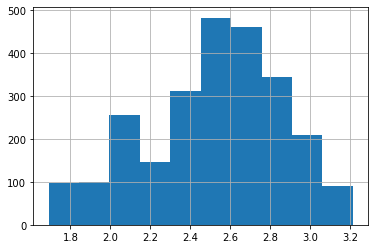

In [22]:
np.log(data_new.Interest_Rate).hist()

C:\Users\Dilber\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='Interest_Rate', ylabel='Density'>

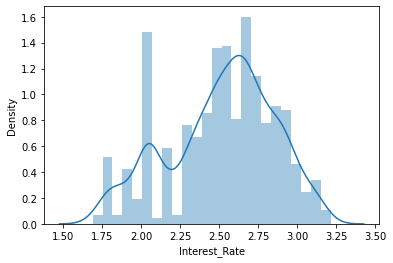

In [23]:
sns.distplot(np.log(data_new.Interest_Rate))

In [24]:
data_new["ln_Interest_Rate"]= np.log(data_new["Interest_Rate"])

In [25]:
corrm=data_new.corr()

corrm.to_csv('corrm.csv')

<AxesSubplot:>

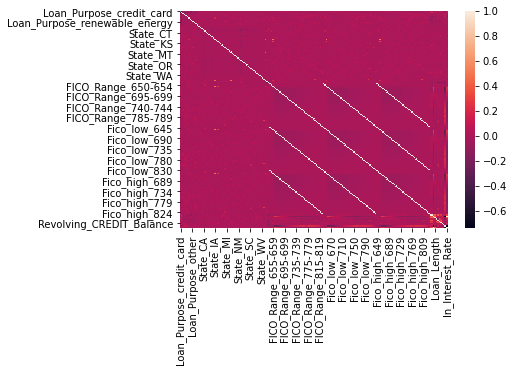

In [26]:
sns.heatmap(data_new.corr())

### d. There is relationship between FICO scores and Home Ownership. It means that, People with owning home will have high FICO scores.

In [27]:
loans.Home_Ownership.value_counts().unique

<bound method Series.unique of MORTGAGE    1147
RENT        1146
OWN          200
OTHER          5
NONE           1
Name: Home_Ownership, dtype: int64>

In [28]:
Loans_num.columns

Index(['Amount_Requested', 'Amount_Funded_By_Investors', 'Interest_Rate',
       'Loan_Length', 'Debt_To_Income_Ratio', 'Monthly_Income',
       'Open_CREDIT_Lines', 'Revolving_CREDIT_Balance',
       'Inquiries_in_the_Last_6_Months', 'Employment_Length', 'Fico_avg'],
      dtype='object')

In [29]:
own_home = Loans_num.Fico_avg[loans.Home_Ownership=='OWN']

In [30]:
own_home

5       670.0
34      675.0
54      680.0
59      755.0
73      665.0
        ...  
2456    710.0
2465    755.0
2466    670.0
2486    665.0
2496    740.0
Name: Fico_avg, Length: 200, dtype: float64

In [31]:
stats.ttest_ind(own_home,loans.Fico_avg,nan_policy='omit')

Ttest_indResult(statistic=0.24791948563645977, pvalue=0.8042155833887459)

####  p value is 0.804 . Hencet we cannot reject the null hypothesis. Wecan somewhat say that the people having own houses have a better FICO score

## BUSINESS PROBLEM2:
### We would like to assess if there is any difference in the average price quotes provided by Mary and Barry

In [4]:
Price=pd.read_csv(r"C:\Users\Sushant\Desktop\PYTHON\Basic Statistics - Hypothesis Testing\Price_Quotes.csv")

In [5]:
Price

,Order_Number,Barry_Price,Mary_Price
0,1,126,114
1,2,110,118
2,3,138,114
3,4,142,111
4,5,146,129
5,6,136,119
6,7,94,97
7,8,103,104
8,9,140,127
9,10,152,133


In [34]:
Price.columns

Index(['Order_Number', 'Barry_Price', 'Mary_Price'], dtype='object')

In [35]:
Barry = Price.Barry_Price.mean()

In [36]:
Mary = Price.Mary_Price.mean()

In [37]:
print(Barry),print(Mary)

124.33333333333333
114.75


(None, None)

### there is a clear difference in the average price quotes of Mary and Barry

## BUSINESS PROBLEM 3: 
### Determine what effect, if any, the reengineering effort had on the incidence behavioral problems and staff turnover. i.e To determine if the reengineering effort changed the critical incidence rate. Isthere evidence that the critical incidence rate improved?

In [6]:
TreatF = pd.read_csv(r"C:\Users\Sushant\Desktop\PYTHON\Basic Statistics - Hypothesis Testing\Treatment_Facility.csv")

In [7]:
TreatF.head(5)

,Month,Reengineer,Employee_Turnover,VAR4,VAR5
0,1,Prior,0.0000,24.390244,42.682927
1,2,Prior,6.0606,19.354839,25.806452
2,3,Prior,12.1212,35.087719,146.198830
3,4,Prior,3.3333,18.404908,110.429448
4,5,Prior,12.9032,17.964072,23.952096


In [40]:
TreatF = TreatF.rename(columns={'VAR4': 'TRFF', 'VAR5': 'CI'})

In [42]:
TreatF.head(2)

,Month,Reengineer,Employee_Turnover,TRFF,CI
0,1,Prior,0.0000,24.390244,42.682927
1,2,Prior,6.0606,19.354839,25.806452


In [43]:
PR_CI = TreatF.CI[TreatF.Reengineer=='Prior']
PO_CI = TreatF.CI[TreatF.Reengineer=='Post']
PR_TO = TreatF.Employee_Turnover[TreatF.Reengineer=='Prior']
PO_TO = TreatF.Employee_Turnover[TreatF.Reengineer=='Post']

In [44]:
stats.ttest_ind(PR_CI,PO_CI, nan_policy='omit')

Ttest_indResult(statistic=1.6279144253528646, pvalue=0.12091989189884149)

####  hence as p value is 0.12 we cannot reject the null hyp. Reengineering has no  effect on the Critical incident

In [45]:
stats.ttest_ind(PR_TO,PO_TO, nan_policy='omit')

Ttest_indResult(statistic=-1.770306704753604, pvalue=0.09361109345535304)

####  since as p value is 0.09  we cannot reject the null hyp.

## BUSINESS PROBLEM 4: 
### We will focus on the prioritization system. If the system is working, then high priority jobs, on average, should be completed more quickly than medium priority jobs,and medium priority jobs should be completed more quickly than low priority jobs. Use the data provided to determine whether thisis, in fact, occurring

In [8]:
PA = pd.read_csv(r"C:\Users\Sushant\Desktop\PYTHON\Basic Statistics - Hypothesis Testing\Priority_Assessment.csv")

In [9]:
PA.head(10)

,Days,Priority
0,3.3,High
1,7.9,Medium
2,0.3,High
3,0.7,Medium
4,8.6,Medium
5,0.3,High
6,0.3,High
7,0.3,High
8,72.9,High
9,15.9,Medium


In [48]:
HP = PA.Priority=='High'
MP = PA.Priority=='Medium'
LP = PA.Priority=='Low'

In [49]:
print(stats.spearmanr(HP, MP))

SpearmanrResult(correlation=-0.8084788387213114, pvalue=1.7390710767545788e-149)


In [50]:
print(stats.spearmanr(MP, LP))

SpearmanrResult(correlation=-0.2717107851130757, pvalue=2.5002291310462077e-12)


#### for both the tests the p value is less than 0.5 and hence we can reject the null hyp. and accept the alternative hyp.
#### here x increase and y tend to decrease , which can be concluded from the negative sp.corr

## BUSINESS PROBLEM 5: 
### Use the survey resultsto addressthe following questions
### What isthe overall level of customer satisfaction?



In [10]:
Films = pd.read_csv(r"C:\Users\Sushant\Desktop\PYTHON\Basic Statistics - Hypothesis Testing\Films.csv")

In [11]:
Films.head(10)

,_rowstate_,Movie,Gender,Marital_Status,Sinage,Parking,Clean,Overall,Age,Income,Hear_About
0,0,Ferris Buellers Day Off,Female,Married,2.0,2.0,2.0,2.0,3.0,1.0,5
1,0,Ferris Buellers Day Off,Female,Single,1.0,1.0,1.0,1.0,2.0,1.0,5
2,0,Ferris Buellers Day Off,Male,Married,2.0,4.0,3.0,2.0,4.0,1.0,5
3,0,Ferris Buellers Day Off,Female,Married,1.0,3.0,2.0,2.0,4.0,1.0,5
4,0,Ferris Buellers Day Off,Female,Married,1.0,1.0,1.0,1.0,3.0,3.0,1
5,0,Ferris Buellers Day Off,Female,Married,1.0,1.0,1.0,1.0,3.0,3.0,5
6,0,Ferris Buellers Day Off,Male,Married,2.0,2.0,2.0,2.0,3.0,3.0,5
7,0,Ferris Buellers Day Off,Female,Single,1.0,1.0,3.0,1.0,3.0,NaN,4
8,0,Ferris Buellers Day Off,Female,Single,1.0,1.0,3.0,1.0,3.0,NaN,4
9,0,Ferris Buellers Day Off,Female,Single,2.0,3.0,2.0,2.0,3.0,1.0,4


In [53]:
Films.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 330 entries, 0 to 329
Data columns (total 11 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   _rowstate_      330 non-null    int64  
 1   Movie           330 non-null    object 
 2   Gender          330 non-null    object 
 3   Marital_Status  328 non-null    object 
 4   Sinage          328 non-null    float64
 5   Parking         328 non-null    float64
 6   Clean           327 non-null    float64
 7   Overall         328 non-null    float64
 8   Age             328 non-null    float64
 9   Income          314 non-null    float64
 10  Hear_About      323 non-null    object 
dtypes: float64(6), int64(1), object(4)
memory usage: 28.5+ KB


In [54]:
Films.isnull().sum()

_rowstate_         0
Movie              0
Gender             0
Marital_Status     2
Sinage             2
Parking            2
Clean              3
Overall            2
Age                2
Income            16
Hear_About         7
dtype: int64

In [55]:
Films.Overall.mean(skipna = True)

1.6189024390243902

#### hence we can say that the overall CSAT level is 1.62

### What factors are linked to satisfaction?


In [56]:
Films.corrwith(Films.Overall)

_rowstate_         NaN
Sinage        0.382881
Parking       0.516585
Clean         0.349412
Overall       1.000000
Age          -0.034171
Income       -0.004050
dtype: float64

#### the major factors linked to CSAT is parking and sinage , also cleanliness plays a vital role..but the age and income have a very less correlation


### What is the demographic profile of Film on the Rocks patrons?


In [12]:
Films_New = pd.read_csv(r"C:\Users\Sushant\Desktop\PYTHON\Basic Statistics - Hypothesis Testing\Films.csv")

In [13]:
Films_New.head()

,_rowstate_,Movie,Gender,Marital_Status,Sinage,Parking,Clean,Overall,Age,Income,Hear_About
0,0,Ferris Buellers Day Off,Female,Married,2.0,2.0,2.0,2.0,3.0,1.0,5
1,0,Ferris Buellers Day Off,Female,Single,1.0,1.0,1.0,1.0,2.0,1.0,5
2,0,Ferris Buellers Day Off,Male,Married,2.0,4.0,3.0,2.0,4.0,1.0,5
3,0,Ferris Buellers Day Off,Female,Married,1.0,3.0,2.0,2.0,4.0,1.0,5
4,0,Ferris Buellers Day Off,Female,Married,1.0,1.0,1.0,1.0,3.0,3.0,1


In [59]:
Films_New.isnull().sum()

_rowstate_         0
Movie              0
Gender             0
Marital_Status     2
Sinage             2
Parking            2
Clean              3
Overall            2
Age                2
Income            16
Hear_About         7
dtype: int64

In [60]:
Films_New.dropna(inplace=True)

In [61]:
Films_New.isnull().sum()

_rowstate_        0
Movie             0
Gender            0
Marital_Status    0
Sinage            0
Parking           0
Clean             0
Overall           0
Age               0
Income            0
Hear_About        0
dtype: int64

In [62]:
Films_New.Age = Films_New['Age'].astype('str')
Films_New['Age'] = Films_New.Age.str.replace('1.0',' 1-12').str.replace('2.0',' 13-30').str.replace('3.0',' 31-60').str.replace('4.0','60+')

<ipython-input-62-9746efd4301c>:2: FutureWarning: The default value of regex will change from True to False in a future version.
  Films_New['Age'] = Films_New.Age.str.replace('1.0',' 1-12').str.replace('2.0',' 13-30').str.replace('3.0',' 31-60').str.replace('4.0','60+')


In [63]:
Films_New['Gender'] = Films_New.Gender.str.replace('1', 'Male').str.replace('2','Female')
Films_New['Marital_Status'] = Films_New.Marital_Status.str.replace('Slngle','Single').str.replace('2','Single').str.replace('1','Married')

In [64]:
profile = pd.pivot_table(data=Films_New,values='Overall',index=['Age','Marital_Status','Movie'],columns=['Gender'])

In [65]:
profile

Gender                                           Female      Male
Age    Marital_Status Movie                                      
 1-12  Married        Willy Wonka              1.000000       NaN
       Single         Ferris Buellers Day Off  1.666667  3.000000
                      Old School               1.000000  1.000000
                      Willy Wonka              1.428571  1.500000
 13-30 Married        Ferris Buellers Day Off  3.000000  2.000000
                      Old School               1.500000  1.000000
                      Willy Wonka              1.500000  1.000000
       Single         Ferris Buellers Day Off  1.525000  1.952381
                      Old School               1.666667  1.428571
                      Willy Wonka              1.645833  1.720000
 31-60 Married        Ferris Buellers Day Off  1.470588  1.500000
                      Old School               1.400000  1.333333
                      Willy Wonka              1.652174  1.583333
       Single         Ferris Buellers Day Off  1.600000  1.625000
                      Old School               1.000000       NaN
                      Willy Wonka              1.769231  1.400000
60+    Married        Ferris Buellers Day Off  2.000000  1.666667
                      Willy Wonka              2.000000       NaN
       Single         Ferris Buellers Day Off  1.000000       NaN

<AxesSubplot:xlabel='Age,Marital_Status,Movie'>

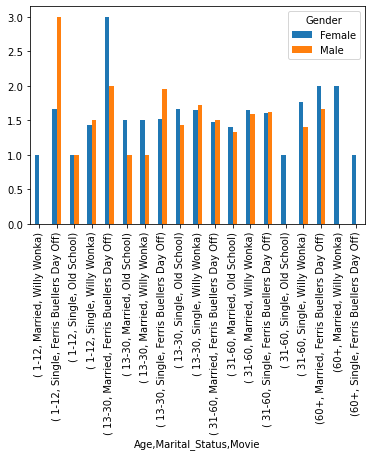

In [66]:
profile.plot.bar()

### In what media outlet(s) should the film series be advertised?

In [67]:
Films_New.head(10)

,_rowstate_,Movie,Gender,Marital_Status,Sinage,Parking,Clean,Overall,Age,Income,Hear_About
0,0,Ferris Buellers Day Off,Female,Married,2.0,2.0,2.0,2.0,31-60,1.0,5
1,0,Ferris Buellers Day Off,Female,Single,1.0,1.0,1.0,1.0,13-30,1.0,5
2,0,Ferris Buellers Day Off,Male,Married,2.0,4.0,3.0,2.0,60+,1.0,5
3,0,Ferris Buellers Day Off,Female,Married,1.0,3.0,2.0,2.0,60+,1.0,5
4,0,Ferris Buellers Day Off,Female,Married,1.0,1.0,1.0,1.0,31-60,3.0,1
5,0,Ferris Buellers Day Off,Female,Married,1.0,1.0,1.0,1.0,31-60,3.0,5
6,0,Ferris Buellers Day Off,Male,Married,2.0,2.0,2.0,2.0,31-60,3.0,5
9,0,Ferris Buellers Day Off,Female,Single,2.0,3.0,2.0,2.0,31-60,1.0,4
10,0,Ferris Buellers Day Off,Male,Married,2.0,2.0,2.0,2.0,60+,1.0,1
12,0,Ferris Buellers Day Off,Female,Single,1.0,1.0,1.0,1.0,31-60,1.0,1


In [68]:
Films_New['Hear_About'] = Films_New['Hear_About'].replace('1','television').replace('2','newspaper').replace('3','radio').replace('4','website').replace('5','Word of Mouth')

<AxesSubplot:>

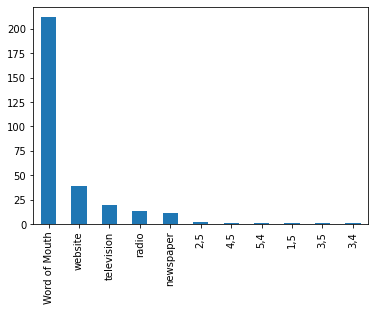

In [69]:
Films_New.Hear_About.value_counts().plot.bar()

#### Word of mouth is the best way for the advertisement but as we no its not a part of media ,
#### hence website is the best way for advertisement